In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme(style='white') # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#465BBB', '#3F8FCE', '#7ABBCE', '#3A3865', '#A82F43', '#612A37', '#DC5433', '#F29457']
b1 = '#465BBB'
b2 = '#3F8FCE'
b3 = '#7ABBCE'
b4 = '#3A3865'
black1 = '#22212A'
black2 = '#2D1E21'
or1 = '#A82F43'
or2 = '#612A37'
or3 = '#DC5433'
or4 = '#F29457'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{txfonts}'  # Use TX Times font

# Set up your font properties (optional)
font = FontProperties()
font.set_family('serif')
font.set_name('Times')  # Times font


%matplotlib inline 

In [3]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
from data_access import*
from helper import*
from RR_lyrae_params import*
from blazhko_analysis import*

# Analysis of RR Lyrae - methodology

---

In [4]:
#| code-fold: false
# LINEAR DATA
# ------------
dataL = fetch_LINEAR_sample(data_home='../inputs')

---

# PERIOD CALCULATION

The Lomb-Scargle method of computing the period of a variable star using light curves involves fitting multi-level sinusoidal waves to our light curve data over various trial periods, and the period with the most prominent strength or the best fit is the actual period.

This is the formula for the Lomb-Scargle periodogram:

$$P(ω)= \frac{1}{2σ^2}​*(\frac{[∑y_k cosω(t_k−τ)]^2}{∑cos^2 ω(t_k−τ)} + \frac{[∑y_k sin ω(t_k−τ)]^2}{∑ sin^2 ω(t_k−τ)})$$

We use the Lomb-Scargle periodogram because it is the most famous tool for determining the periodic variable stars' period. It combines multiple methods of analysis, with its core being in Fourier analysis, and it operates with non-uniformly spaced data, such is the nature of light curves.

### Light curve folding

**Light curve phasing or folding** is when we condense the entire timeseries of the light curve into one *phase*, or one cycle of variability. Phase is defined with the period of the light curve, as such: $$phase = \frac{time}{period} - int(\frac{time}{period})$$ This function defines the period as a value from 0 to 1 defining how far in is the star in its variability cycle. We can then adjust the `time` array using this function.

---

# LIGHT CURVE FITTING

**Light curve fitting** requires a sophisticated function which uses Fourier analysis to correctly fit a curve through light curve `time`, `mag` and `magerr` data. We can define how many terms we want our fit to have. *The more terms we use, the more complicated shapes we can graph*. The fitting is an essential part of light curve analysis, as we can then calculate the goodness of fit and monitor how that fit changes over long periods of time, like in the case of `LINEAR` and `ZTF`.

#### `Chi-2 test`
This test asseses the "goodness of fit" of light curves, by comparing the fitted values and the actual magnitude values of the light curve. The lower the chi-2 value, the better the correlation between the observed and expected values (based on some model), and the higher the chi-2 value, the poorer the correlation. At which point the value is too high or too low is determined by the statistician, based on the degrees of freedom and the nature of the data. The chi-2 value for every point of a light curve is calculated as such: $$\chi^2 = \sum{\frac{(O_i - E_i)^2}{E_i}}$$

---

# PERIODOGRAM ANALYSIS

As a final step of the RR Lyrae analysis process, we need to analyze the periodograms which the Lomb-Scargle method produces. A periodogram is a plot of the power of each frequency, telling us which frequency, or period, fits the light curve best. We can use this periodogram to look for signs of the Blazhko Effect: if there are 2 subsequent local peaks around the maximum, the star is likely a BE star. 

We determine the existence of local peaks by folding the periodogram by the maximum peak, multiplying each folded part to amplify signals so they are easier to detect, and we then search for the next strongest peak. Our program also calculates the 1-year anomaly, making sure that we really find the correct frequencies.

---

### Data setup

In [5]:
Lrrlyr = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
end = 'ffinal'
dataZTF = np.load("../outputs/ZTF_dataset_"+end+".npy", allow_pickle=True)

Lids = Lrrlyr['LINEARobjectID'].to_numpy()
rectascension = Lrrlyr['ra'].to_numpy() # list of rectascension coordinates
declination = Lrrlyr['dec'].to_numpy() # list of declination coordinates

test = len(Lids)
ZTF_data_best = []
periodograms = []
lc_analysis = {}
fits = []

In [6]:
Lrrlyr.head()

,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,LINEARobjectID
0,119.526443,46.962120,1.166,0.369,1.018,0.269,-0.254138,0.619,-0.313,-0.567,16.37,301,1,29848
1,119.712975,52.149574,1.175,0.386,1.100,0.205,-0.191591,0.487,-0.291,-0.879,16.46,284,1,50402
2,119.187241,53.379295,1.123,0.207,1.074,0.210,-0.275092,0.624,-0.547,-0.322,16.54,276,1,62892
3,120.294960,40.932457,1.180,0.237,1.087,0.368,-0.170871,0.753,-0.121,-0.927,15.39,177,1,91437
4,120.124542,40.656620,1.178,-0.145,0.835,0.277,-0.503252,0.550,0.140,-0.650,16.98,222,2,95250


### Analysis of RR Lyrae

---

In [7]:
for i in tqdm(range(test)):
        # designated LINEAR id
        Lid = Lids[i]
        # SEARCHING FOR ZTF DATA
        for j in dataZTF:
           # If the ID's match
           if j[0]==Lid:
               # check if ZTF has data for this ID
               if j[1].shape[0] == 0:
                   # if not, save None and break from for loop
                   dataZ = None
                   break
               else:
                   # if there is data, assign it and also break
                   dataZ = j[1]
                   break
        # if there is no data, continue with main loop (skip this iteration)
        if dataZ is None:
            continue
    
               
        # PERIOD ANALYSIS
        # -----------------
        Plinear, fL, pL, tL, mL, meL = LINEARLS(dataL, Lid, 3) 
        Pztf, fZ, pZ, tZ, mZ, meZ = ZTFs(dataZ, Lid, 3)

        # if the period is 0, skip the star
        if Plinear==0.0 or Pztf==0.0:
            continue
        
        # Accounting for significant figures
        Plinear = round(Plinear, 6)
        Pztf = round(Pztf, 6)
        Pmean = round((Plinear+Pztf)/2, 6)
        Pratio = round((Pztf/Plinear), 6)

        # PERIODOGRAM ANALYSIS
        # Custom algorithm for finding local blazhko peaks
        # --------------------
        fFoldedL, pFoldedL, fMainPeakL, fBlazhkoPeakL, BlazhkoPeriodL, BpowerRatioL, BsignificanceL = getBlazhkoPeak(fL, pL)
        fFoldedZ, pFoldedZ, fMainPeakZ, fBlazhkoPeakZ, BlazhkoPeriodZ, BpowerRatioZ, BsignificanceZ = getBlazhkoPeak(fZ, pZ)

        # Saving periodogram data
        periodograms.append((Lid, (fL, pL, fFoldedL, pFoldedL), (fZ, pZ, fFoldedZ, pFoldedZ)))

        # CHI-2 MODELING
        # ----------------
        ntermsModels = 6
        LINEAR_Plinear = LCanalysisFromP(tL, mL, meL, Plinear, ntermsModels)
        LINEAR_Pmean = LCanalysisFromP(tL, mL, meL, Pmean, ntermsModels)

        ZTF_Pztf = LCanalysisFromP(tZ, mZ, meZ, Pztf, ntermsModels)
        ZTF_Pmean = LCanalysisFromP(tZ, mZ, meZ, Pmean, ntermsModels)

        # SAVING DATA
        # -------------
        STAR = [Plinear, Pztf, Pmean, Pratio, np.size(tL), round(LINEAR_Plinear['chi2dof'], 1), round(LINEAR_Plinear['chi2dofR'], 1),
            round(LINEAR_Pmean['chi2dof'],1), round(LINEAR_Pmean['chi2dofR'],1), round(LINEAR_Plinear['mmax'],2), round(LINEAR_Plinear['A'],2),
            np.size(tZ), round(ZTF_Pztf['chi2dof'],1), round(ZTF_Pztf['chi2dofR'],1), round(ZTF_Pmean['chi2dof'],1), round(ZTF_Pmean['chi2dofR'],1), round(ZTF_Pztf['mmax'],2), round(ZTF_Pztf['A'],2),
            fMainPeakL, fBlazhkoPeakL, BlazhkoPeriodL, BpowerRatioL, BsignificanceL, fMainPeakZ, 
            fBlazhkoPeakZ, BlazhkoPeriodZ, BpowerRatioZ, BsignificanceZ]
            
        lc_analysis[Lid] = STAR
        fits.append((Lid, (LINEAR_Plinear, LINEAR_Pmean, ZTF_Pztf, ZTF_Pmean)))
        ZTF_data_best.append((Lid, tZ, mZ, meZ))

        # saving the data on the computer
        if i%10==0:
            # save dictionary to pkl file
            with open('../outputs/lc_analysis_'+end+'.pkl', 'wb') as fp:
                pickle.dump(lc_analysis, fp)
            with open("../outputs/periodograms_"+end+".pkl", "wb") as x:
                pickle.dump(periodograms, x)
            FITS = np.array(fits, dtype=object)
            np.save("../outputs/fits_"+end+".npy", FITS, allow_pickle=True)
            ZTF_data_lca = np.array(ZTF_data_best, dtype=object)
            np.save("../outputs/ztf_data_filter"+end+".npy", ZTF_data_lca, allow_pickle=True)

# FINAL SAVE
# ---------------
# save dictionary to pkl file
with open('../outputs/lc_analysis_'+end+'.pkl', 'wb') as fp:
    pickle.dump(lc_analysis, fp)
with open("../outputs/periodograms_"+end+".pkl", "wb") as x:
    pickle.dump(periodograms, x)
FITS = np.array(fits, dtype=object)
np.save("../outputs/fits_"+end+".npy", FITS, allow_pickle=True)
ZTF_data_lca = np.array(ZTF_data_best, dtype=object)
np.save("../outputs/ztf_data_filter"+end+".npy", ZTF_data_lca, allow_pickle=True)

  0%|          | 0/2941 [00:00<?, ?it/s]

 27%|██▋       | 790/2941 [3:22:14<11:26:48, 19.16s/it]/Users/emadonev/anaconda3/envs/rr_lyrae/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/core.py:243: RuntimeWarning: divide by zero encountered in scalar divide
  df = 1.0 / baseline / samples_per_peak
/Users/emadonev/anaconda3/envs/rr_lyrae/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/core.py:249: RuntimeWarning: divide by zero encountered in scalar divide
  avg_nyquist = 0.5 * n_samples / baseline
/Users/emadonev/anaconda3/envs/rr_lyrae/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/core.py:252: RuntimeWarning: invalid value encountered in scalar subtract
  Nf = 1 + int(np.round((maximum_frequency - minimum_frequency) / df))
100%|██████████| 2941/2941 [14:28:59<00:00, 17.73s/it]   


### Creating a Pandas dataframe from dictionary

In [9]:
cols = ['Plinear', 'Pztf', 'Pmean', 'Pratio', 'NdataLINEAR', 'L_chi2dof', 'L_chi2dofR', 'Lmean_chi2dof', 'Lmean_chi2dofR', 'Lmmax', 'Lampl',
         'NdataZTF', 'Zchi2dof',
            'Zchi2dofR', 'Zmean_chi2dof', 'Zmean_chi2dofR',
            'Zmmax', 'Zampl',
            'MainPeakL', 'BlazhkoPeakL', 'BlazhkoPeriodL','BpowerRatioL','BsignificanceL',
            'MainPeakZ', 'BlazhkoPeakZ', 'BlazhkoPeriodZ', 'BpowerRatioZ', 'BsignificanceZ']
LC_ANALYSIS = pd.DataFrame.from_dict(lc_analysis, orient='index', columns=cols)
LC_ANALYSIS.index.name='LINEAR id'
LC_ANALYSIS = LC_ANALYSIS.reset_index()

In [10]:
display(LC_ANALYSIS)

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,MainPeakL,BlazhkoPeakL,BlazhkoPeriodL,BpowerRatioL,BsignificanceL,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7953,1.8328,26.6205,0.0455,7.4839,1.7952,1.7982,333.3333,0.2573,10.0729
1,50402,0.643303,0.643294,0.643298,0.999986,284,0.6,0.7,0.6,0.7,...,1.5545,1.6223,14.7351,0.0776,7.1946,1.5545,1.5918,26.8420,0.0027,8.9208
2,62892,0.530776,0.530785,0.530780,1.000017,276,1.1,0.9,1.1,1.0,...,1.8840,1.9519,14.7319,0.0658,7.1233,1.8840,1.9433,16.8634,0.0048,13.1609
3,91437,0.674733,0.674737,0.674735,1.000006,177,2.8,1.3,2.8,1.3,...,1.4821,1.5498,14.7580,0.0816,4.4270,1.4821,1.4849,355.8719,0.0233,16.1566
4,95250,0.313870,0.313876,0.313873,1.000019,222,0.8,0.8,0.9,0.8,...,3.1860,3.2565,14.1844,0.0377,9.9986,3.1860,3.1889,342.4658,0.0028,13.4528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,24251229,0.752008,0.752015,0.752012,1.000009,141,1.4,1.2,1.3,1.2,...,1.3298,1.3597,33.4392,0.2012,5.4697,1.3298,1.3351,185.7010,0.0273,13.7465
2853,24257481,0.291239,0.291218,0.291228,0.999928,303,43.1,5.7,67.1,7.8,...,3.4336,3.4701,27.4048,0.0180,10.5892,3.4339,3.4394,180.6685,0.0066,12.1123
2854,24262387,0.697062,0.348532,0.522797,0.500001,338,2.5,1.2,27.3,5.9,...,1.4346,1.4529,54.7495,0.0782,14.5219,2.8692,2.9373,14.6724,0.0076,21.9778
2855,24262890,0.600460,0.600462,0.600461,1.000003,329,1.0,0.8,1.0,0.8,...,1.6654,1.7019,27.3898,0.0576,13.9389,1.6654,1.6709,181.4882,0.0109,9.3114


In [ ]:
# CONFIGURATION OF PANDAS DATAFRAME
# Making sure every number has the correct number of decimals and filling NaN values with 0
# ====================================

LC_ANALYSIS = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")

LC_ANALYSIS['MainPeakL'] = pd.to_numeric(LC_ANALYSIS['MainPeakL'], errors='coerce').fillna(0)
LC_ANALYSIS['BlazhkoPeakL'] = pd.to_numeric(LC_ANALYSIS['BlazhkoPeakL'], errors='coerce').fillna(0)
LC_ANALYSIS['BlazhkoPeriodL'] = pd.to_numeric(LC_ANALYSIS['BlazhkoPeriodL'], errors='coerce').fillna(0)
LC_ANALYSIS['BpowerRatioL'] = pd.to_numeric(LC_ANALYSIS['BpowerRatioL'], errors='coerce').fillna(0)
LC_ANALYSIS['BsignificanceL'] = pd.to_numeric(LC_ANALYSIS['BsignificanceL'], errors='coerce').fillna(0)
LC_ANALYSIS['MainPeakZ'] = pd.to_numeric(LC_ANALYSIS['MainPeakZ'], errors='coerce').fillna(0)
LC_ANALYSIS['BlazhkoPeakZ'] = pd.to_numeric(LC_ANALYSIS['BlazhkoPeakZ'], errors='coerce').fillna(0)
LC_ANALYSIS['BlazhkoPeriodZ'] = pd.to_numeric(LC_ANALYSIS['BlazhkoPeriodZ'], errors='coerce').fillna(0)
LC_ANALYSIS['BpowerRatioZ'] = pd.to_numeric(LC_ANALYSIS['BpowerRatioZ'], errors='coerce').fillna(0)
LC_ANALYSIS['BsignificanceZ'] = pd.to_numeric(LC_ANALYSIS['BsignificanceZ'], errors='coerce').fillna(0)

LC_ANALYSIS['Pratio'] = round(LC_ANALYSIS['Pratio'], 6)
LC_ANALYSIS['Plinear'] = round(LC_ANALYSIS['Plinear'], 6)
LC_ANALYSIS['Pztf'] = round(LC_ANALYSIS['Pztf'], 6)
LC_ANALYSIS["Pmean"] = round(LC_ANALYSIS["Pmean"], 6)
LC_ANALYSIS['Lampl'] = round(LC_ANALYSIS['Lampl'], 2)
LC_ANALYSIS['Zampl'] = round(LC_ANALYSIS['Zampl'], 2)
LC_ANALYSIS['L_chi2dofR'] = round(LC_ANALYSIS['L_chi2dofR'], 1)
LC_ANALYSIS['Lmean_chi2dofR'] = round(LC_ANALYSIS['Lmean_chi2dofR'], 1)
LC_ANALYSIS['Zchi2dofR'] = round(LC_ANALYSIS['Zchi2dofR'], 1)
LC_ANALYSIS['Zmean_chi2dofR'] = round(LC_ANALYSIS['Zmean_chi2dofR'], 1)
LC_ANALYSIS['L_chi2dof'] = round(LC_ANALYSIS['L_chi2dof'], 1)
LC_ANALYSIS['Lmean_chi2dof'] = round(LC_ANALYSIS['Lmean_chi2dof'], 1)
LC_ANALYSIS['Zchi2dof'] = round(LC_ANALYSIS['Zchi2dof'], 1)
LC_ANALYSIS['Zmean_chi2dof'] = round(LC_ANALYSIS['Zmean_chi2dof'], 1)
LC_ANALYSIS['Ampl_diff'] = round(abs(LC_ANALYSIS['Lampl'] - LC_ANALYSIS['Zampl']), 2)
LC_ANALYSIS['dP'] = round(abs((LC_ANALYSIS['Plinear']-LC_ANALYSIS['Pztf'])/LC_ANALYSIS['Pmean']),5)
LC_ANALYSIS['MainPeakL'] = round(LC_ANALYSIS['MainPeakL'], 4)
LC_ANALYSIS['BlazhkoPeakL'] =round(LC_ANALYSIS['BlazhkoPeakL'], 4)
LC_ANALYSIS['BlazhkoPeriodL'] = round(LC_ANALYSIS['BlazhkoPeriodL'], 4)
LC_ANALYSIS['BpowerRatioL'] = round(LC_ANALYSIS['BpowerRatioL'], 4)
LC_ANALYSIS['BsignificanceL'] = round(LC_ANALYSIS['BsignificanceL'], 4)
LC_ANALYSIS['MainPeakZ'] = round(LC_ANALYSIS['MainPeakZ'], 4)
LC_ANALYSIS['BlazhkoPeakZ'] = round(LC_ANALYSIS['BlazhkoPeakZ'], 4)
LC_ANALYSIS['BlazhkoPeriodZ'] = round(LC_ANALYSIS['BlazhkoPeriodZ'], 4)
LC_ANALYSIS['BpowerRatioZ'] = round(LC_ANALYSIS['BpowerRatioZ'], 4)
LC_ANALYSIS['BsignificanceZ'] = round(LC_ANALYSIS['BsignificanceZ'], 4)
LC_ANALYSIS['IndicatorType'] = 'NaN'
LC_ANALYSIS['ChiType'] = 'NaN'
LC_ANALYSIS['BE_score'] = 'NaN'

LC_ANALYSIS.to_csv("../outputs/LC_ANALYSIS_"+end+".csv", index=False)
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

---

After the analysis has finished, we will demonstrate an example of a LINEAR and ZTF pair.

In [5]:
# Choosing and loading a LINEAR ID
ID = 7
end = 'ffinal'
LC_ANALYSIS = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)
Lids = list(LC_ANALYSIS['LINEAR id'])

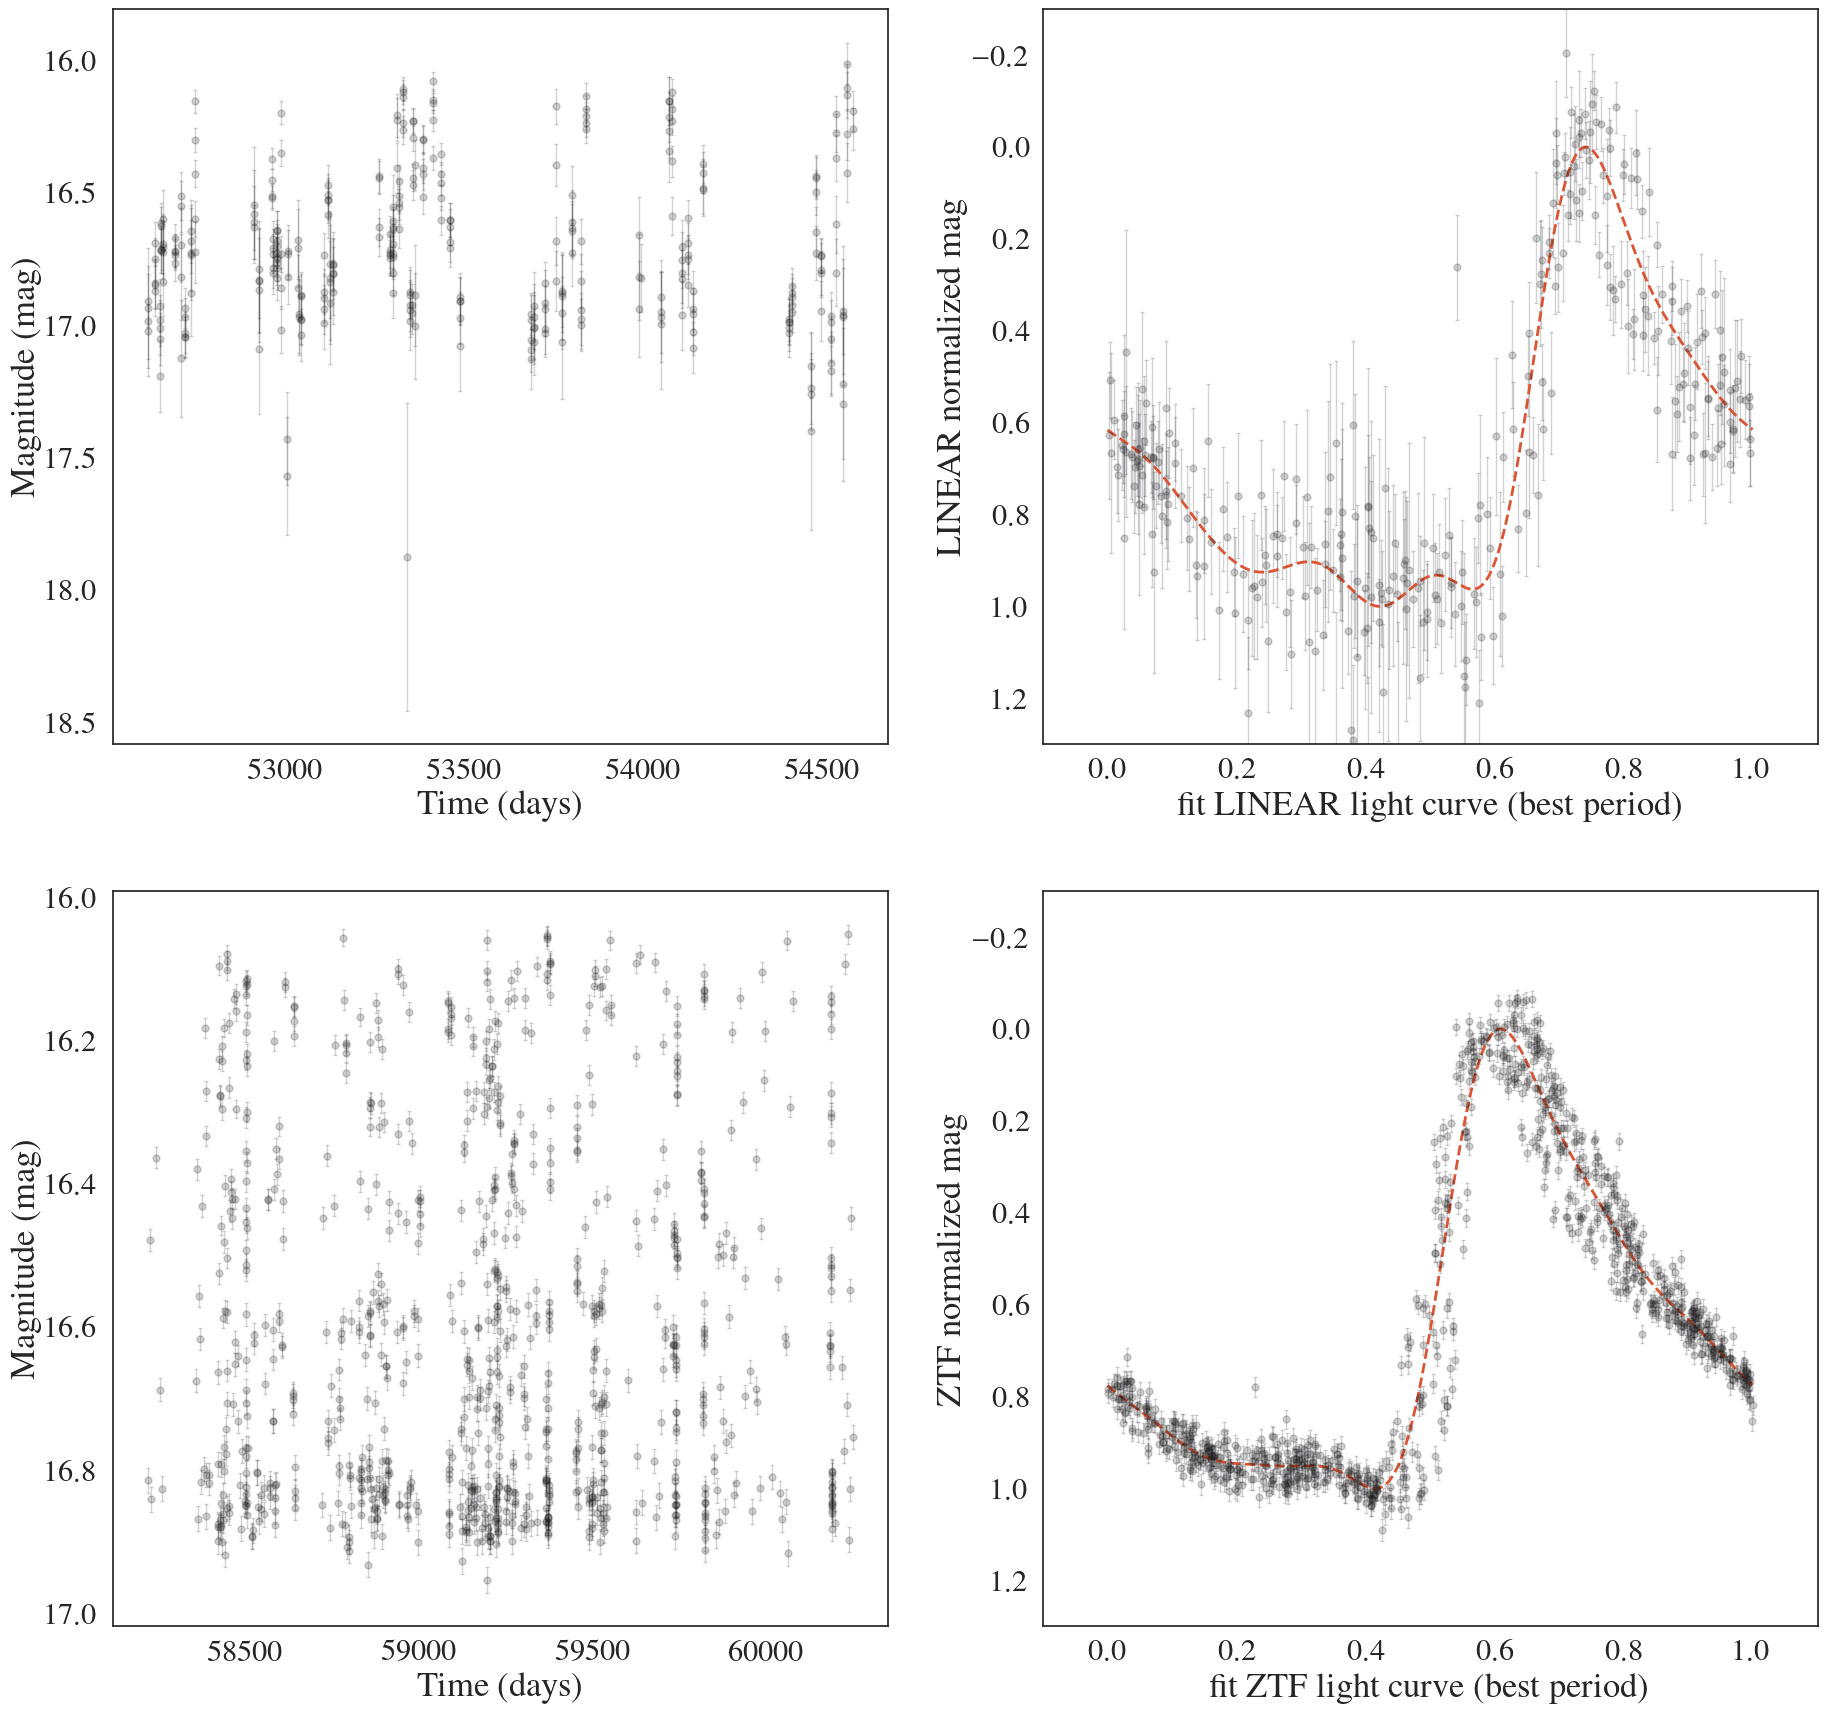

In [9]:
# selecting the data
total_num = len(Lids)
Lid = Lids[ID]
lc_data_ID = dataL.get_light_curve(Lid)
time, mag, magerr = lc_data_ID.T
tZ, mZ, meZ = ztf_data[ID][1], ztf_data[ID][2], ztf_data[ID][3]
for n, j in enumerate(fits):
    if j[0]==Lid:
        break

L1 = fits[n][1][0]
L2 = fits[n][1][2]

# setting up the plot
fig = plt.figure(figsize=(22, 21))
fig.set_facecolor('white')

# LINEAR full observation time
#--------
ax = fig.add_subplot(221)
ax.errorbar(time, mag, magerr, fmt='.k', ecolor=black1,lw=1, ms=10, capsize=1.5,alpha=0.2)
ax.set_xlabel('Time (days)',fontproperties=font, fontsize=25)
ax.set_ylabel('Magnitude (mag)', fontproperties=font, fontsize=25)
#fig.subtitle('LINEAR object {0}'.format(Lid), fontproperties=font, fontsize=38)
ax.invert_yaxis()
ax.tick_params(labelsize=22)

# LINEAR phased light curve
# -----
ax = fig.add_subplot(222)

ax.set_xlabel('fit LINEAR light curve (best period)', fontproperties=font, fontsize=25)
ax.set_ylabel('LINEAR normalized mag', fontproperties=font, fontsize=25)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(1.3, -0.3)
# data
xx, yy, zz = sort3arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'])
ax.errorbar(xx, yy, zz, fmt='.k', ecolor=black1, lw=1, ms=10, capsize=1.5, alpha=0.2)
# fit for Plinear
ax.plot(L1['modelPhaseGrid'], L1['modTemplate'], or3, markeredgecolor=or3, lw=2, fillstyle='top', linestyle='dashed')
ax.tick_params(labelsize=22)

# ZTF full observation time
#--------
ax = fig.add_subplot(223)

ax.errorbar(tZ, mZ, meZ, fmt='.k', ecolor=black1,lw=1, ms=10, capsize=1.5,alpha=0.2)
ax.set_xlabel('Time (days)',fontproperties=font, fontsize=25)
ax.set_ylabel('Magnitude (mag)', fontproperties=font, fontsize=25)
ax.invert_yaxis()
ax.tick_params(labelsize=22)

# ZTF phased light curve
# -----
ax = fig.add_subplot(224)

ax.set_xlabel('fit ZTF light curve (best period)', fontproperties=font, fontsize=25)
ax.set_ylabel('ZTF normalized mag', fontproperties=font, fontsize=25)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(1.3, -0.3)
# data
xx, yy, zz = sort3arr(L2['dataPhasedTime'], L2['dataTemplate'], L2['dataTemplateErr'])
ax.errorbar(xx, yy, zz, fmt='.k', ecolor=black1, lw=1, ms=10, capsize=1.5, alpha=0.2)
# fit for Plinear
ax.plot(L2['modelPhaseGrid'], L2['modTemplate'], or3, markeredgecolor=or3, lw=2, fillstyle='top', linestyle='dashed')
#plt.tight_layout()
ax.tick_params(labelsize=22)

plt.savefig('../AJsubmission/lc_pair.png', dpi=400)